In [1]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
from matplotlib import pyplot as plt 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.metrics import precision_score
import joblib
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#特征选择的包
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,SelectPercentile
from sklearn.feature_selection import chi2

#stacking的包
from functools import reduce
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold               #交叉
import re
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

In [2]:
def k_means(X, n):
    
    #画出SSE的评估图
    sse = []
    for i in range(2, 11):
        clf = KMeans(n_clusters=i)
        clf.fit(X)
        sse.append(clf.inertia_)
    
    print(len(sse))
    print(sse)
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 11), sse, marker='o')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.show()
    
    clf = KMeans(n_clusters=n)
    clf.fit(X)
    label = clf.labels_
    print("label的形状: {}".format(label.shape))
    
    #可以为类别画画饼状图
    class_ = []
    for i in range(n):
        class_.append(str(i))   
    count_ = np.bincount(label)
    plt.pie(count_, labels=class_,  shadow=True, autopct='%1.1f%%') #最后一个参数可以计算比例
    plt.title('类别占比')
    plt.show()
    return label

In [3]:
def PCA_process(data, n):
    """
    主成分分析，作为五监督式学习，可对数据进行预处理，然后降低监督式学习的计算复杂度以及提高精准度

    data: 原始数据
    n: 选择的主成分个数
    Returns
    -------
    PCA后的X数据

    """
    max_cols, max_rows = data.shape
    max_cols = max_cols - 2     #对于该数据集，第一列用户ID和最后一列RESP不作为训练数据
    #这里尝试进行Standard放缩法
    X = data.iloc[:, 2:max_cols]
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    pca = PCA(n_components=n, random_state=0)
    pca.fit(X_scaled)
    rato = pca.explained_variance_ratio_
    print("主成分贡献率：{}".format(rato))
    print(pca.components_)
    print("主成分总贡献率：{}".format(sum(rato)))
    X_pca = pca.transform(X_scaled)
    
    #上面n_components就是主成分的个数，分为2个,所以现在数据X的形状变为(28798, 46)
    #下面对两个主成分包含的信息进行可视化
    """
    plt.matshow(pca.components_, cmap='viridis')
    plt.yticks([0, 1], ['First component', 'second somponent'])
    plt.colorbar()
    plt.xticks(range(2, max_cols), ['{}'.format(i) for i in range(2, max_cols)], ha='left')
    plt.xlabel("Feature")
    plt.ylabel("Principal label")
    plt.show()
    """
    return X_pca

In [4]:
#提高采样比  这个是第一步就要做的
def sampling(data, pos_num, neg_num): #抽样采样
    pos_list = list(data[data.RESP==1].index)
    neg_list = list(data[data.RESP==0].index)
    pos_sample = data.iloc[pos_list[:pos_num], :]
    neg_sample = data.iloc[neg_list[:neg_num], :]
    samples = pd.concat([pos_sample,neg_sample])
    append_test = data.iloc[neg_list[neg_num:], :]
    samples_dict = {'samples':samples, 'append_test':append_test}
    return samples_dict

In [5]:
from imblearn.over_sampling import RandomOverSampler

def RandomOverSampler_sampling(train_x,train_y): #随机过采样
    ros = RandomOverSampler(random_state=0)

    sampling_train_x, sampling_train_y = ros.fit_resample(train_x, train_y)
    
    return sampling_train_x, sampling_train_y

from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

def smote_sampling(train_x,train_y): #smote采样
    #print(data)
    # X = data.loc[:, data.columns != 'RESP']
    # y = data.loc[:, data.columns == 'RESP']

    # train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0)
    overstamp = SMOTE(random_state=0)
    
    SMOTE_train_x, SMOTE_train_y = overstamp.fit_resample(train_x, train_y)
    # 统计数据的标签0，1个数
    # print(pd.value_counts(SMOTE_train_y, sort=True).sort_index())
    #print(SMOTE_train_x)
    #print(SMOTE_train_y)
    #print(SMOTE_train_y.value_counts())
    #print(test_y.value_counts())
    
    return SMOTE_train_x, SMOTE_train_y

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
# result_x,result_y = smote_sampling(X_train, y_train)

# print(Counter(result_y))


#borderline-smote采样

# from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

def borderline_smote_sampling(train_x,train_y): 
    sm = BorderlineSMOTE(random_state=42,kind="borderline-1")
    SMOTE_train_x, SMOTE_train_y = sm.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(SMOTE_train_y))
    return SMOTE_train_x, SMOTE_train_y

#SVMSMOTE采样

# from collections import Counter
from imblearn.over_sampling import SVMSMOTE

def SVMSMOTE_sampling(train_x,train_y): 
    sm = SVMSMOTE(random_state=42)
    SMOTE_train_x, SMOTE_train_y = sm.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(SMOTE_train_y))
    return SMOTE_train_x, SMOTE_train_y

#KMeansSMOTE采样

from imblearn.over_sampling import KMeansSMOTE

def KMeansSMOTE_sampling(train_x,train_y): 
    sm = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.1)
    SMOTE_train_x, SMOTE_train_y = sm.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(SMOTE_train_y))
    return SMOTE_train_x, SMOTE_train_y

#SMOTENC采样

from imblearn.over_sampling import SMOTENC

def SMOTENC_sampling(train_x,train_y): 
    sm = SMOTENC(categorical_features=[0, 2], random_state=0)
    SMOTE_train_x, SMOTE_train_y = sm.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(SMOTE_train_y))
    return SMOTE_train_x, SMOTE_train_y

# ADASYN自适应合成抽样

from imblearn.over_sampling import ADASYN

def ADASYN_sampling(train_x,train_y): 
    ada = ADASYN(random_state=42, sampling_strategy='minority')
    SMOTE_train_x, SMOTE_train_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(SMOTE_train_y))
    return SMOTE_train_x, SMOTE_train_y

# smote-variants库含有多种SMOTE方法

# ClusterCentroids采样

from imblearn.under_sampling import ClusterCentroids

def ClusterCentroids_sampling(train_x,train_y):
    ada = ClusterCentroids(random_state=42)
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# RandomUnderSampler采样

from imblearn.under_sampling import RandomUnderSampler

def RandomUnderSampler_sampling(train_x,train_y): 
    ada = RandomUnderSampler(random_state=42)
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# EditedNearestNeighbours采样

from imblearn.under_sampling import EditedNearestNeighbours

def EditedNearestNeighbours_sampling(train_x,train_y): 
    ada = EditedNearestNeighbours()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# RepeatedEditedNearestNeighbours采样

from imblearn.under_sampling import RepeatedEditedNearestNeighbours

def RepeatedEditedNearestNeighbours_sampling(train_x,train_y): 
    ada = RepeatedEditedNearestNeighbours()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# AllKNN采样

from imblearn.under_sampling import AllKNN

def AllKNN_sampling(train_x,train_y): 
    ada = AllKNN()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# CondensedNearestNeighbour采样

from imblearn.under_sampling import CondensedNearestNeighbour

def CondensedNearestNeighbour_sampling(train_x,train_y): 
    ada = CondensedNearestNeighbour()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# OneSidedSelection采样

from imblearn.under_sampling import OneSidedSelection

def OneSidedSelection_sampling(train_x,train_y): 
    ada = OneSidedSelection()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# NeighbourhoodCleaningRule采样

from imblearn.under_sampling import NeighbourhoodCleaningRule

def NeighbourhoodCleaningRule_sampling(train_x,train_y): 
    ada = NeighbourhoodCleaningRule()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# InstanceHardnessThreshold采样

from imblearn.under_sampling import InstanceHardnessThreshold

def InstanceHardnessThreshold_sampling(train_x,train_y): 
    ada = InstanceHardnessThreshold()
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# SMOTEENN采样

from imblearn.combine import SMOTEENN

def SMOTEENN_sampling(train_x,train_y): 
    ada = SMOTEENN(random_state=42)
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

# SMOTETomek采样

from imblearn.combine import SMOTETomek

def SMOTETomek_sampling(train_x,train_y): 
    ada = SMOTETomek(random_state=42)
    sampling_x, sampling_y = ada.fit_resample(train_x, train_y)
    print('Resampled dataset shape %s' % Counter(sampling_y))
    return sampling_x, sampling_y

In [6]:
def profit(y_pred, y_test):
    cost = 5 * sum(y_pred) #2 * sum(y_pred)
    pay_back = 0
    for i in range(y_pred.shape[0]):
        if y_pred[i]==1 and y_test[i]==1:
            pay_back = pay_back + 34 #28.4 
    profit = pay_back - cost
    profit_rate = profit / cost
    print(cost, pay_back, profit, profit_rate)



In [7]:
from sklearn.feature_selection import VarianceThreshold

def 方差特征选择(X,方差阈值):
    
    print(VarianceThreshold(threshold=方差阈值).fit_transform(X).shape)
    X_new = VarianceThreshold(threshold=方差阈值).fit_transform(X)
    return X_new

In [ ]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
fpr,tpr,threshold = roc_curve(y_test, y_prob[:, 1]) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值
print(roc_auc)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

9
[46330012562.60623, 34035289187.462296, 26140838523.29053, 22993497199.496628, 20091785088.730988, 18186743891.859787, 16549069706.581974, 15426146495.818552, 14425988022.922424]


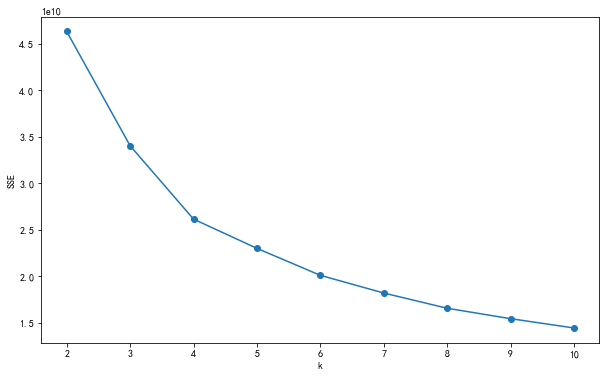

label的形状: (28798,)


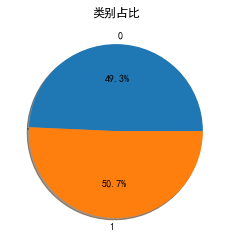

In [4]:
#1、读取数据
data = pd.read_excel("原始数据集.xlsx".replace('\\','/'))

#2、删除不必要的特征
data.drop('HHKEY',axis=1, inplace=True)     #HHKEY用户IDx
data.drop('CLUSTYPE', axis=1,inplace=True)  #CLUSTYPE生活方式聚类
data.drop('ZIP_CODE', axis=1,inplace=True)  #ZIP_CODE邮政编码

#3、K_means进行聚类
K_means_label = k_means(data, 2)
data['k_means'] = K_means_label

#4、进行采样

# samples_dict = sampling(data, 4762, 4762) #10000      #正样本数量为4762，负样本为10000
# samples = samples_dict['samples']
# append_test = samples_dict['append_test']       #这块数据后面要加在测试集数上

# y = np.array(samples.RESP)
# samples.drop("RESP", axis=1, inplace=True)      #删除不需要的列
# X = np.array(samples)
# print("训练和原始测试数据的大小：{}".format(X.shape))

In [16]:
#只运行一次
y = np.array(data.RESP)
data.drop("RESP", axis=1, inplace=True)      #删除不需要的列
X = np.array(data)
print("训练和原始测试数据的大小：{}".format(X.shape))


indices = np.arange(X.shape[0])
x_train,x_test,y_train,y_test, indices_train, indices_test = train_test_split(X,y,indices, test_size = 0.25)


#将训练数据索引和测试数据索引写入txt文件    只运行一次
# train_file_path = os.path.join(basemodel_save_dir, '服装店_train.txt').replace('\\', '/')
# print(train_file_path)
train_file = open('服装店_train.txt', 'w', encoding='gbk')
for indexs in indices_train:
    train_file.write(str(indexs))
    train_file.write('\n')
train_file.close()

# test_file_path = os.path.join(basemodel_save_dir, '服装店_test.txt').replace('\\', '/')
# print(test_file_path)
test_file = open('服装店_test.txt', 'w', encoding='gbk')
for indexs in indices_test:
    test_file.write(str(indexs))
    test_file.write('\n')
test_file.close()


训练和原始测试数据的大小：(28798, 47)


In [5]:
train_file = open('服装店_train.txt', 'r', encoding='gbk')
test_file  = open('服装店_test.txt',  'r', encoding='gbk')
train_indices = train_file.readlines()
test_indices  = test_file.readlines()
train_indices = [eval(item.strip()) for item in train_indices]  #处理读进来的char
test_indices =  [eval(item.strip()) for item in  test_indices]
train_file.close()
test_file.close()
#开始按照索引分割data
train_set = data.iloc[train_indices, :]
test_set  = data.iloc[test_indices,  :]

In [6]:
y_train = np.array(train_set.RESP)
train_set.drop("RESP", axis=1, inplace=True)      #删除不需要的列
x_train = np.array(train_set)

y_test = np.array(test_set.RESP)
test_set.drop("RESP", axis=1, inplace=True)      #删除不需要的列
x_test = np.array(test_set)

F:\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
scaler = StandardScaler().fit(x_train) # fit生成规则
x_train = scaler.transform(x_train) # 将规则应用于训练集
x_test = scaler.transform(x_test)  # 将规则应用于测试集

In [7]:
(x_train.shape, x_test.shape)

((21598, 47), (7200, 47))

### 使用GridSearchCV对基模型进行调参(十折CV)

In [13]:
import os
def gridsearchcv(X, y, X_test, y_test, path):
    #需要自动调参的模型
    models = [
                KNeighborsClassifier(),
                
                # LinearDiscriminantAnalysis(),
                DecisionTreeClassifier(random_state=0, criterion="entropy"),
                RandomForestClassifier(random_state=2)
    ]

    #不需要自动调参的模型
    models2 =   [
                    LinearDiscriminantAnalysis(n_components=1),
                    LogisticRegression(penalty='l2', C=1.0, random_state=None, solver='lbfgs', max_iter=3000, multi_class='ovr', verbose=0),
                    GaussianNB(),
                    # MLPClassifier(solver='adam',random_state=0,hidden_layer_sizes=[50, 50]),
                    SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                        decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
                        max_iter=-1, random_state=None, shrinking=True,
                        tol=0.001, verbose=False, probability=True),    
                    XGBClassifier(
                    silent=1 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
                    nthread=4,# cpu 线程数 默认最大
                    learning_rate= 0.3, # 如同学习率
                    min_child_weight=1,
                    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                    #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                    #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
                    # max_depth=10, #10 构建树的深度，越大越容易过拟合
                    gamma=0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
                    subsample=1, # 随机采样训练样本 训练实例的子采样比
                    max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
                    colsample_bytree=1, # 生成树时进行的列采样
                    reg_lambda=1,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                    #reg_alpha=0, # L1 正则项参数
                    #scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
                    #objective= 'multi:softmax', #多分类的问题 指定学习任务和相应的学习目标
                    #num_class=10, # 类别数，多分类与 multisoftmax 并用
                    n_estimators=100, #树的个数
                    seed=1000 #随机种子
                    #eval_metric= 'auc'
                    )     
                ]


    names = ['knn', 'tree', 'forest']
    names2 = ['LDA', 'LogisticRegression', 'GaussianNB', 'svc', 'XGBClassifier']
    para_dicts = [{"n_neighbors":range(5, 8)}, {"max_depth":range(2, 20)}, {"n_estimators":range(10, 31)}]
    models_acc = []
    models_precision = []
    models_recall = []
    models_f1 = []


    #需要自动调参的模型
    for i in range(len(models)):
        model = models[i]
        para_dict = para_dicts[i]
        grid_search = GridSearchCV(model, para_dict, cv=10, scoring='f1')
        grid_search.fit(X, y)
        print(grid_search.best_params_, grid_search.best_score_)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = metrics.accuracy_score(y_pred, y_test)
        precision = metrics.precision_score(y_pred, y_test)
        recall = metrics.recall_score(y_pred, y_test)
        f1 = metrics.f1_score(y_pred, y_test)
        models_acc.append(acc)
        models_precision.append(precision)
        models_recall.append(recall)
        models_f1.append(f1)
        print("{}   {}  {}   {}  {}".format(names[i], acc, precision, recall, f1))
        # joblib.dump(best_model, 'C:/Users/Administrator/Desktop/大创/kaggle data/result/单模型加采样/{}.pkl'.format(names[i]))
        pth = os.path.join(path, '{}.pkl'.format(names[i])).replace('\\', '/')
        print(pth)
        joblib.dump(best_model, pth)
        

    #不需要自动调参的模型
    for i in range(len(models2)):
        model = models2[i]
        grid_search = GridSearchCV(model, param_grid={}, cv=10, scoring='f1')
        grid_search.fit(X, y)
        print(grid_search.best_params_, grid_search.best_score_)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = metrics.accuracy_score(y_pred, y_test)
        precision = metrics.precision_score(y_pred, y_test)
        recall = metrics.recall_score(y_pred, y_test)
        f1 = metrics.f1_score(y_pred, y_test)
        models_acc.append(acc)
        models_precision.append(precision)
        models_recall.append(recall)
        models_f1.append(f1)
        print("{}   {}  {}  {}  {}".format(names2[i], acc,     precision, recall, f1))
        pth = os.path.join(path, '{}.pkl'.format(names2[i]))
        joblib.dump(best_model, pth)
    

In [ ]:
gridsearchcv(x_train, y_train, x_test, y_test, 'C:/Users/Administrator/Desktop/pkl/BaseModel不采样')

In [26]:
#重新加载并评估模型
def performance(basemodel_save_dir):
    # basemodel_save_dir = 'C:/Users/Administrator/Desktop/pkl/BaseModel采样'
    names1 = ['knn', 'tree', 'forest']
    names2 = ['LDA', 'LogisticRegression', 'GaussianNB', 'svc', 'XGBClassifier']
    names = names1 + names2
    base_result_path = os.path.join(basemodel_save_dir, 'report_to_file.xls').replace('\\', '/')
    print(base_result_path)
    df = pd.DataFrame()
    for name in names:
        model_path = os.path.join(basemodel_save_dir, '{}.pkl'.format(name)).replace('\\', '/')
        print(model_path)
        model = joblib.load(model_path)
        print(model)
        pred = model.predict(x_test)
        report = metrics.classification_report(y_test, pred, output_dict=True)  
        report = pd.DataFrame(report).transpose()
        df = pd.concat([df, report], axis=0)
        #同时计算利润
        #混淆矩阵如下
        cm = metrics.confusion_matrix(pred, y_test)
        print("混淆矩阵:\n{}".format(cm))
        expend = np.array([[0, 0], [-5, 29]])
        income = expend * cm
        avg_income = sum(sum(income))/7200
        print("AVG_INCOME: {}".format(avg_income))
    df.to_excel(base_result_path, sheet_name='Sheet1')

In [ ]:
#算了 跑得太慢 直接做NCL吧
under_sampling_func_set = [  
                    ClusterCentroids_sampling, RandomUnderSampler_sampling,
                    EditedNearestNeighbours_sampling, RepeatedEditedNearestNeighbours_sampling,
                    AllKNN_sampling,
                     OneSidedSelection_sampling, NeighbourhoodCleaningRule_sampling,
                     InstanceHardnessThreshold_sampling
                    ] #remove CondensedNearestNeighbour_sampling

combine_sampling_func_set = [SMOTEENN_sampling, SMOTETomek_sampling]

# over_sampling_func_set = [RandomOverSampler_sampling, smote_sampling, 
#                      borderline_smote_sampling, SVMSMOTE_sampling,
#                     KMeansSMOTE_sampling, SMOTENC_sampling, ADASYN_sampling] 
over_sampling_func_set = [RandomOverSampler_sampling, smote_sampling, 
                     borderline_smote_sampling, SVMSMOTE_sampling,
                      SMOTENC_sampling]

sampling_func_set = under_sampling_func_set + combine_sampling_func_set + over_sampling_func_set\

under_name = [
        'ClusterCentroids_sampling', 'RandomUnderSampler_sampling',
        'EditedNearestNeighbours_sampling', 'RepeatedEditedNearestNeighbours_sampling',
        'AllKNN_sampling',
        'OneSidedSelection_sampling', 'NeighbourhoodCleaningRule_sampling',
        'InstanceHardnessThreshold_sampling'
]
combine_name = ['SMOTEENN_sampling', 'SMOTETomek_sampling']         

over_name = ['RandomOverSampler_sampling', 'smote_sampling', 'borderline_smote_sampling', 'SVMSMOTE_sampling','SMOTENC_sampling']

#调试时注意修改report名字
for i, samplingfunc in enumerate(under_sampling_func_set):
    print("-------------{}----------------".format(samplingfunc))
    sampling_X_train,sampling_y_train = samplingfunc(x_train, y_train)
    sampling_X_train_shape.append(sampling_X_train.shape)
    sampling_y_train_shape.append(sampling_y_train.shape)
    print("--------------SHAPE-------------")
    print("X_train:{}   y_train:{}".format(sampling_X_train.shape, sampling_y_train.shape))
    gridsearchcv(sampling_X_train, sampling_y_train, x_test, y_test, 'C:/Users/Administrator/Desktop/pkl/BaseModel采样')
    performance('C:/Users/Administrator/Desktop/pkl/BaseModel采样/{}report.xlsx'.format(under_name[i]))

In [15]:
#NCL采样
x_train,y_train = NeighbourhoodCleaningRule_sampling(x_train, y_train)

# gridsearchcv(x_train, y_train, x_test, y_test, 'C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样')

Resampled dataset shape Counter({0: 12879, 1: 3588})


In [ ]:
basemodel_save_dir = 'C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样'
performance(basemodel_save_dir)

In [ ]:
#训练完之后将数据导入导入到excel中
result_all = []
result_all.append(result_sampling_precision)
result_all.append(result_sampling_recall)
result_all.append(result_sampling_f1)
result_file = open('results_stacking.xls', 'w', encoding='gbk')

In [ ]:
result_file.write('\n')
for m in range(result_all[0].shape[0]):
    for n in range(result_all[0].shape[1]):
        result_file.write('\t')
        for p in range(len(result_all)):
            result_file.write(str(result_all[p][m][n]))
            result_file.write('\t')
        result_file.write('\n')
    result_file.write('\n')
result_file.close()

In [51]:
tree = LogisticRegression()
tree.fit(x_train, y_train)
ypred = tree.predict(x_test)
print('DT Reports\n',classification_report(y_test, ypred))

DT Reports
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      6026
           1       0.64      0.24      0.35      1174

    accuracy                           0.85      7200
   macro avg       0.76      0.61      0.63      7200
weighted avg       0.83      0.85      0.82      7200



In [57]:
y_pred = np.ones_like(ypred)

In [65]:
cm = metrics.confusion_matrix(ypred, y_test)     #tn, fp, fn, tp
cm

array([[5871,  895],
       [ 155,  279]], dtype=int64)

In [66]:
expend = np.array([[0, 0], [-5, 26.4]])
income = expend * cm
income

array([[   0. ,    0. ],
       [-775. , 7365.6]])

In [67]:
avg_income = sum(sum(income))/7200
avg_income

0.9153611111111111

In [50]:
2*(0.306*0.96)/(0.306+0.96)

0.4640758293838862

In [ ]:
lr = LogisticRegression()
xgb = XGBClassifier(n_estimators=20)
lda = LinearDiscriminantAnalysis()
forest = RandomForestClassifier(n_estimators=59, random_state=2)
tree = DecisionTreeClassifier(max_depth=8,random_state=0)
mlp = MLPClassifier(solver='adam', random_state=0, hidden_layer_sizes=[100, 100])
nb = GaussianNB()
svc = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
              max_iter=-1, probability=True, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
#   ['decisiontree','MLP','XGBoost', 'RandomForest', 'NB']
#第二种方法
#第一层
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100)
forest = RandomForestClassifier(n_estimators=100)
from sklearn.ensemble import ExtraTreesClassifier
extree = ExtraTreesClassifier(n_estimators=100)
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=150)
gbk = GradientBoostingClassifier(n_estimators=100)
#第二层
lr = LogisticRegression(solver="lbfgs")

stack = StackingCVClassifier(                   #默认是5折交叉
    classifiers=(tree, mlp, xgb, forest, nb, svc),
    meta_classifier=lr,
    use_features_in_secondary=True,
    store_train_meta_features=True,
    shuffle=True,
    random_state=0,
    cv=10
    )
stack.fit(x_train, y_train)
y_pred = stack.predict(x_test)
joblib.dump(stack, 'C:/Users/Administrator/Desktop/pkl/stacking/stack不采样5.pkl')
report = metrics.classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_excel('C:/Users/Administrator/Desktop/pkl/stacking/stacking不采样结果5.xlsx', sheet_name='Sheet1')
print('stacking Reports\n',report)

In [25]:
import joblib
model = joblib.load("C:/Users/Administrator/Desktop/结果/bank/stack(第二层forest).pkl")
print(model.meta_classifier)

RandomForestClassifier()


C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/report_to_file.xls
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/knn.pkl
KNeighborsClassifier()
0.7497237269956255
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/tree.pkl
DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0)
0.8300816422419375
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/forest.pkl
RandomForestClassifier(n_estimators=25, random_state=2)
0.8214534999103826
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/LDA.pkl
LinearDiscriminantAnalysis(n_components=1)
0.8080796672680735
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/LogisticRegression.pkl
LogisticRegression(max_iter=3000, multi_class='ovr')
0.8383966186276277
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/GaussianNB.pkl
GaussianNB()
0.7879948530812815
C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样/stacking.pkl


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=0.5)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=0.5)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=0.5)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.

StackingCVClassifier(classifiers=(XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                enable_categorical=False,
                                                gamma=None, gpu_id=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_delta_step=None,
                                                max_depth=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints...
       

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=1.0) ###假正率为横坐标，真正率为纵坐标做曲线
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=0.5)


0.8250258250590429


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_29524/1348640939.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=0.5)


<Figure size 1600x1200 with 0 Axes>

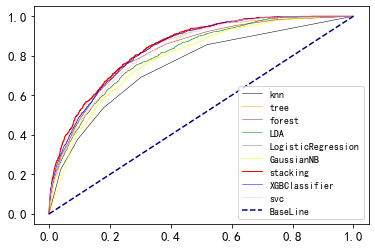

In [10]:
#查看aoc
basemodel_save_dir = 'C:/Users/Administrator/Desktop/pkl/BaseModel_NCL采样'
names1 = ['knn', 'tree', 'forest']
names2 = ['LDA', 'LogisticRegression', 'GaussianNB', 'stacking', 'XGBClassifier', 'svc']
colors = ['black', 'orange', 'brown', 'green', 'grey', 'yellow', 'red', 'blue', 'pink']
names = names1 + names2
base_result_path = os.path.join(basemodel_save_dir, 'report_to_file.xls').replace('\\', '/')
print(base_result_path)
plt.figure(figsize=(8,6), dpi=200)
plt.figure()
plt.rc('font', family='SimHei', size=13)
for i, name in enumerate(names):
    model_path = os.path.join(basemodel_save_dir, '{}.pkl'.format(name)).replace('\\', '/')
    print(model_path)
    model = joblib.load(model_path)
    print(model)
    pred = model.predict_proba(x_test)[:, 1]
    fpr,tpr,threshold = metrics.roc_curve(y_test, pred) ###计算真正率和假正率
    roc_auc = metrics.auc(fpr,tpr) ###计算auc的值
    print(roc_auc)
    if colors[i] == 'red':
        plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=1.0) ###假正率为横坐标，真正率为纵坐标做曲线
    else:
        plt.plot(fpr, tpr, 'b', label=name, color=colors[i], linewidth=0.5)
plt.plot([0, 1], [0, 1], color='navy', label='BaseLine', linestyle='--')   #baseline
plt.rcParams.update({'font.size': 10})
plt.legend()
plt.show()

In [25]:
#通过测试集对训练好的模型进行测试

modelist = ['decisiontree','MLP','XGBoost', 'SVM', 'RandomForest', 'NB']
newfeature_list = []
newtestdata_list = []
for modelname in modelist:
    # clf_first = SelectModel(modelname)
    if modelname == 'decisiontree':
        clf_first = joblib.load('DecisionTreeClassifier_stacking.pkl')
    elif modelname == 'MLP':
        clf_first = joblib.load('MLPClassifier_stacking.pkl')
    elif modelname == 'XGBoost':
        clf_first = joblib.load('XGBClassifier_stacking.pkl')
    elif modelname == 'SVM':
        clf_first = joblib.load('SVC_stacking.pkl')
    elif modelname == 'RandomForest':
        clf_first = joblib.load('RandomForestClassifier_stacking.pkl')
    elif modelname == 'NB':
        clf_first = joblib.load('GaussianNB_stacking.pkl')
    # oof_train_ ,oof_test_= get_oof(clf=clf_first,n_folds=10,X_train=X_train,y_train=y_train,X_test=X_valid) #概率结果
    oof_X_test = clf_first.predict_proba(x_test)
    oof_X_train = clf_first.predict_proba(x_train)
    newfeature_list.append(oof_X_train)
    newtestdata_list.append(oof_X_test)
newfeature = reduce(lambda x,y:np.concatenate((x,y),axis=1),newfeature_list)
newtestdata = reduce(lambda x,y:np.concatenate((x,y),axis=1),newtestdata_list)
print("newfeature SHAPE:{}".format(newfeature.shape))
print("newtestdata SHAPE:{}".format(newtestdata.shape))

print("y_test SHAPE:{}".format(y_test.shape)) 
second_model = joblib.load('logistic_model.pkl')   
y_pred = second_model.predict(newtestdata)
print("Stacking {}".format(metrics.classification_report(y_pred, y_test)))


newfeature SHAPE:(16467, 12)
newtestdata SHAPE:(7200, 12)
y_test SHAPE:(7200,)
Stacking               precision    recall  f1-score   support

           0       0.88      0.91      0.89      5847
           1       0.54      0.47      0.50      1353

    accuracy                           0.82      7200
   macro avg       0.71      0.69      0.70      7200
weighted avg       0.82      0.82      0.82      7200



In [27]:
report = metrics.classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_excel('C:/Users/Administrator/Desktop/pkl/stacking/NCL采样(原来方法).xlsx', sheet_name='Sheet1')

In [16]:
def logistic_stacking(X_train, X_test, y_train, y_test):
    # global Logistic_bestAcc
    logreg = LogisticRegression()
    logreg = LogisticRegression(penalty='l2', C=1.0, random_state=None, solver='lbfgs', max_iter=3000, multi_class='ovr', verbose=0,)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print("准确率：{}".format(metrics.precision_score(y_test, y_pred)))
    print("召回率：{}".format(metrics.recall_score(y_test, y_pred)))
    print("F1 Score：{}".format(metrics.f1_score(y_test, y_pred)))
    joblib.dump(logreg, 'logistic_model.pkl')

    # if metrics.precision_score(y_test, y_pred) > Logistic_bestAcc:
    #     Logistic_bestAcc = metrics.precision_score(y_test, y_pred)
    #     joblib.dump(logreg, 'Logistic_Model_best.pkl')
    return metrics.precision_score(y_test, y_pred), metrics.recall_score(y_test, y_pred), metrics.f1_score(y_test, y_pred)


def get_oof(clf,n_folds,X_train,y_train,X_test):
    ntrain = X_train.shape[0]               #train的样本数
    ntest =  X_test.shape[0]                #test的样本数
    classnum = len(np.unique(y_train))      #label类别数
    kf = KFold(n_splits=n_folds,random_state=1, shuffle=True)
    oof_train = np.zeros((ntrain,classnum)) #0矩阵      #每一类的概率矩阵
    oof_test = np.zeros((ntest,classnum))
 
 
    for i,(train_index, test_index) in enumerate(kf.split(X_train)):    #kf.split(X_train)返回分割下标
        kf_X_train = X_train[train_index] # 数据
        kf_y_train = y_train[train_index] # 标签
 
        kf_X_test = X_train[test_index]  # k-fold的验证集
 
        clf.fit(kf_X_train, kf_y_train)
        clf_name = re.split("[(]",str(clf))[0] + '_stacking.pkl'  #其实可以不用re模块
        print(clf_name)
        
        joblib.dump(clf, clf_name)
        oof_train[test_index] = clf.predict_proba(kf_X_test)    #(len(kf_X_test), classnum)

        oof_test += clf.predict_proba(X_test)
    oof_test = oof_test/float(n_folds)      #取平均
    return oof_train, oof_test

def SelectModel(modelname):
 
    if modelname == "LogisticRegression":
        print("Run LogisticRegression")
        model = LogisticRegression(random_state=2) 
 
    elif modelname == "XGBoost":
        print("Run XGBoost")
        #from sklearn.ensemble import GradientBoostingClassifier
        model = XGBClassifier(
            silent=0,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
            nthread=4,# cpu 线程数 默认最大
            learning_rate= 0.3, # 如同学习率
            min_child_weight=1,
            # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
            #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
            #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
            max_depth=10, #10 构建树的深度，越大越容易过拟合
            gamma=0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
            subsample=1, # 随机采样训练样本 训练实例的子采样比
            max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
            colsample_bytree=1, # 生成树时进行的列采样
            reg_lambda=1,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
            #reg_alpha=0, # L1 正则项参数
            #scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
            #objective= 'multi:softmax', #多分类的问题 指定学习任务和相应的学习目标
            #num_class=10, # 类别数，多分类与 multisoftmax 并用
            n_estimators=100, #树的个数
            seed=1000 #随机种子
            #eval_metric= 'auc'
            )
    elif modelname == "MLP":
        print("Run MLP")
        # from sklearn.ensemble import RandomForestClassifier
        # model = RandomForestClassifier()
        model = MLPClassifier(solver='adam', random_state=0, hidden_layer_sizes=[100, 100])
    elif modelname == "NB":
        print("Run GaussianNB")
        model = GaussianNB()
    elif modelname == "RandomForest":
        print("Run RandomForset")
        model = RandomForestClassifier(n_estimators=59, random_state=2)
    elif modelname == "SVM":
        print("Run SVM")
        model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
              max_iter=-1, probability=True, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
    elif modelname == "decisiontree":
        print("Run DecisionTree")
        model = DecisionTreeClassifier(max_depth=8,random_state=0)
    elif modelname == "KNN":
        print("Run KNN")
        model = KNeighborsClassifier()
    elif modelname == "LDA":
        print("Run LDA")
        model = KNeighborsClassifier()
    else:
        pass
    return model

total_precission_stacking = []
total_recall_stacking     = []
total_f1_stacking         = []
def Kflod_stacking(X, y, X_test, y_test, k):
    global total_precission_stacking
    global total_recall_stacking
    global total_f1_stacking
    #X_test, y_test 没用上
    kf = RepeatedKFold(n_splits=k, n_repeats=1, random_state=0) #K折交叉验证
    i = 1
    for train_index, valid_index in kf.split(X): # 分割多个验证集测试集
        print("第{}折".format(i))
        i += 1
        X_train = X[train_index]
        X_valid = X[valid_index]
        y_train = y[train_index]
        y_valid = y[valid_index]


        #从这里修改使用何种模型
        modelist = ['decisiontree','MLP','XGBoost', 'SVM', 'RandomForest', 'NB']
        # modelist = ['decisiontree','MLP']
        newfeature_list = []
        newtestdata_list = []
        for modelname in modelist:
            clf_first = SelectModel(modelname)
            oof_train_ ,oof_test_= get_oof(clf=clf_first,n_folds=10,X_train=X_train,y_train=y_train,X_test=X_valid) #概率结果
            newfeature_list.append(oof_train_)
            newtestdata_list.append(oof_test_)
        newfeature = reduce(lambda x,y:np.concatenate((x,y),axis=1),newfeature_list)    
        newtestdata = reduce(lambda x,y:np.concatenate((x,y),axis=1),newtestdata_list)
        print("newfeature: {}".format(newfeature.shape))
        print("newtestdata: {}".format(newtestdata.shape))
        print("y_train: {}".format(y_train.shape))
        print("y_valid: {}".format(y_valid.shape))
        precission_stacking, recall_stacking, f1_stacking = logistic_stacking(newfeature, newtestdata, y_train, y_valid)
        total_precission_stacking.append(precission_stacking)
        total_recall_stacking.append(recall_stacking)
        total_f1_stacking.append(f1_stacking)
    # 显示平均准确率召回率f1值
        if i == 1:
            from sklearn.metrics import roc_curve, auc  ###计算roc和auc
            fpr,tpr,threshold = roc_curve(y_train, y_valid) ###计算真正率和假正率
            roc_auc = auc(fpr,tpr) ###计算auc的值
            print(roc_auc)
            plt.figure()
            lw = 2
            plt.figure(figsize=(10,10))
            plt.plot(fpr, tpr, color='darkorange',
                    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('FP Rate')
            plt.ylabel('TP Rate')
            plt.title('ROC curve')
            plt.legend(loc="lower right")
            plt.show()    

    print("                          准确率               召回率                F1")
    print("stacking {}   {}   {}".format(sum(total_precission_stacking)/len(total_precission_stacking), 
                                                sum(total_recall_stacking)/len(total_recall_stacking), 
                                                sum(total_f1_stacking)/len(total_f1_stacking)))


In [ ]:
Kflod_stacking(x_train, y_train, x_test, y_test, 10)